In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings

conn = sqlite3.connect("../tesla_financials.db")
c = conn.cursor()

df_bs = pd.read_sql("SELECT * FROM BalanceS_new", conn)
df_is = pd.read_sql("SELECT * FROM IncomeS_new", conn)

### Observation the Data

In [2]:
df_bs.drop(31, inplace= True)

In [3]:
df_bs.replace("--", 0, inplace= True)
df_is.replace("--", 0, inplace= True)

In [4]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 0 to 33
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PeriodEnding  33 non-null     object
 1   12/31/2022    29 non-null     object
 2   12/31/2021    29 non-null     object
 3   12/31/2020    29 non-null     object
 4   12/31/2019    29 non-null     object
dtypes: object(5)
memory usage: 1.5+ KB


In [5]:
def type_casting(dataframe):
    for column in dataframe.columns:
        if column != dataframe.columns[0]:
            dataframe[column] = dataframe[column].str.replace('.', '').str.replace(',', '.')
            dataframe[column] = dataframe[column].str.replace('(', '-').str.replace(')', '')
            dataframe[column] = dataframe[column].astype(float)


In [6]:
type_casting(df_bs)
type_casting(df_is)

In [7]:
df_bs.fillna(0, inplace= True)
df_is.fillna(0, inplace= True)

In [8]:
def delete_zero_values(dataframe):
    zero_rows = dataframe[dataframe.iloc[:, 1:].sum(axis=1) == 0]
    dataframe = dataframe.drop(zero_rows.index, inplace = True)

In [9]:
delete_zero_values(df_bs)
delete_zero_values(df_is)

### Calculating the Ratios

#### Liquidity Ratios

In [10]:
total_current_assets = np.array(df_bs.iloc[5:6,1:])
total_current_liabilities = np.array(df_bs.iloc[12:13,1:])
current_ratio = total_current_assets / total_current_liabilities
current_ratio = current_ratio.flatten()
current_ratio

array([1.53195552, 1.37528546, 1.87514037, 1.13462079])

In [11]:
cashandcashequivalents = np.array(df_bs.iloc[0:1,1:])
shorttermliabilities = np.array(df_bs.iloc[10:11,1:])
cash_ratio = cashandcashequivalents / total_current_liabilities
cash_ratio = cash_ratio.flatten()
cash_ratio

array([0.60852147, 0.89195636, 1.36047165, 0.58760664])

#### Financial Structures Ratios

In [12]:
equity = np.array(df_bs.iloc[19:20,1:])
total_assets = np.array(df_bs.iloc[8:9,1:])
equity_assets_ratio = equity / total_assets
equity_assets_ratio = equity_assets_ratio.flatten() 
equity_assets_ratio 

array([0.54293279, 0.48589271, 0.42619084, 0.19289399])

In [13]:
total_liabilities = np.array(df_bs.iloc[16:17, 1:])
equity_liabilities_ratio = equity / total_current_liabilities
equity_liabilities_ratio = equity_liabilities_ratio.flatten()
equity_liabilities_ratio

array([1.67374293, 1.5320477 , 1.55986805, 0.62041811])

#### Turnover Ratios

In [14]:
total_revenues = np.array(df_is.iloc[0:1, 1:])
accounts_receivable_turnover_ratio = total_revenues / total_liabilities
accounts_receivable_turnover_ratio = accounts_receivable_turnover_ratio.flatten()
accounts_receivable_turnover_ratio

array([2.18836803, 1.71552878, 1.07749077, 0.90868086])

In [15]:
working_capital_turnover_ratio = total_revenues / total_current_assets
working_capital_turnover_ratio = working_capital_turnover_ratio.flatten()
working_capital_turnover_ratio

array([1.99090842, 1.98608856, 1.18037205, 2.03073618])

#### Profitability Ratios

In [16]:
net_income = np.array(df_is.iloc[13:14, 1:])
income_revenue_ratio = net_income / total_revenues
income_revenue_ratio = income_revenue_ratio.flatten()
income_revenue_ratio

array([ 1.54133215e-01,  1.02539806e-01,  0.00000000e+00, -3.50720156e-05])

In [17]:
general_expense = np.array(df_is.iloc[4:5, 1:])
sales_general_expenses = net_income / general_expense
sales_general_expenses = sales_general_expenses.flatten()
sales_general_expenses

array([ 3.18195641e+00,  1.22182865e+00,  0.00000000e+00, -3.25774754e-04])

In [18]:
cost_of_revenue = np.array(df_is.iloc[1:2, 1:])
gorss_margin = (total_revenues - cost_of_revenue) / total_revenues
gorss_margin = gorss_margin.flatten()
gorss_margin

array([0.25598439, 0.25279156, 0.21023592, 0.16555456])

In [19]:
df_ratios = {"Years": ["2022", "2021", "2020", "2019"],
    "c_r" :current_ratio,
    "cs_r" : cash_ratio,
    "ea_r" : equity_assets_ratio,
    "el_r" : equity_liabilities_ratio,
    "art_r" : accounts_receivable_turnover_ratio,
    "wct_r" : working_capital_turnover_ratio,
    "ir_r" : income_revenue_ratio,
    "sge" : sales_general_expenses,
    "gm" : gorss_margin
    }
df_ratios = pd.DataFrame(df_ratios)
df_ratios

,Years,c_r,cs_r,ea_r,el_r,art_r,wct_r,ir_r,sge,gm
0,2022,1.531956,0.608521,0.542933,1.673743,2.188368,1.990908,0.154133,3.181956,0.255984
1,2021,1.375285,0.891956,0.485893,1.532048,1.715529,1.986089,0.102540,1.221829,0.252792
2,2020,1.875140,1.360472,0.426191,1.559868,1.077491,1.180372,0.000000,0.000000,0.210236
3,2019,1.134621,0.587607,0.192894,0.620418,0.908681,2.030736,-0.000035,-0.000326,0.165555


In [20]:
# Soruce of Data https://tr.tradingview.com/chart/kdGRESxn/?symbol=NASDAQ%3ATSLA
prices = pd.DataFrame({"Years" : ["2022", "2021", "2020", "2019"], 
                       "Closing_Price": [123.18, 352.26, 235.22, 27.89]
                       })
prices

,Years,Closing_Price
0,2022,123.18
1,2021,352.26
2,2020,235.22
3,2019,27.89


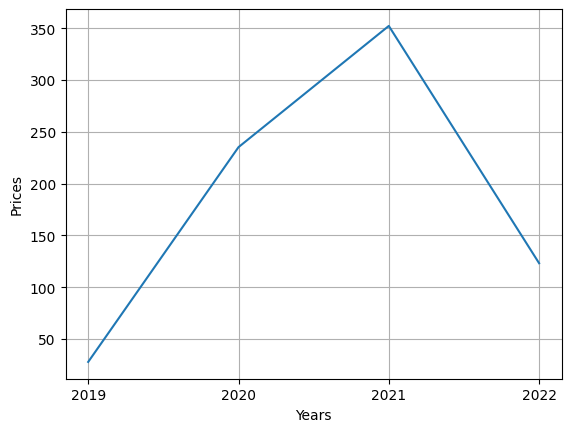

In [21]:
prices_lineplot = prices[::-1]
sns.lineplot(x = "Years",
            y = "Closing_Price",
            data= prices_lineplot)
plt.ylabel("Prices")
plt.grid(True)

### Modeling Data

In [22]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [23]:
datainmodel = pd.merge(df_ratios, prices, on= "Years")
datainmodel

,Years,c_r,cs_r,ea_r,el_r,art_r,wct_r,ir_r,sge,gm,Closing_Price
0,2022,1.531956,0.608521,0.542933,1.673743,2.188368,1.990908,0.154133,3.181956,0.255984,123.18
1,2021,1.375285,0.891956,0.485893,1.532048,1.715529,1.986089,0.102540,1.221829,0.252792,352.26
2,2020,1.875140,1.360472,0.426191,1.559868,1.077491,1.180372,0.000000,0.000000,0.210236,235.22
3,2019,1.134621,0.587607,0.192894,0.620418,0.908681,2.030736,-0.000035,-0.000326,0.165555,27.89


In [24]:
y = datainmodel["Closing_Price"]
X = datainmodel.drop(["Years", "Closing_Price"], axis= 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 42)

In [26]:
const = sm.add_constant(X_train)
model_OLS = sm.OLS(y_train, const).fit()
model_OLS.summary()

/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarn

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Closing_Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 07 Nov 2023   Prob (F-statistic):                nan
Time:                        17:23:08   Log-Likelihood:                 87.419
No. Observations:                   3   AIC:                            -168.8
Df Residuals:                       0   BIC:                            -171.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7834        inf          0        nan         nan         nan
c_r           55.0107        inf          0        nan         nan         nan
cs_r          57.7813        inf          0        nan         nan         nan
ea_r          16.7250        inf          0        nan         nan         nan
el_r          67.9821        inf          0        nan         nan         nan
art_r         10.5277        inf          0        nan         nan         nan
wct_r        -61.4423        inf         -0        nan         nan         nan
ir_r          -0.3244        inf         -0        nan         nan         nan
sge           -6.7251        inf         -0        nan         nan         nan
gm             3.2544        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.859
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.509
Skew:                          -0.675   Prob(JB):                        0.775
Kurtosis:                       1.500   Cond. No.                         5.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
"""

In [30]:
const2 = sm.add_constant(X)
model2 = sm.OLS(y, const2).fit()
model2.summary()

/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/mehmetbuyukgumus/Desktop/Python/Data Science/Projects/Tesla/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarn

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Closing_Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 07 Nov 2023   Prob (F-statistic):                nan
Time:                        17:25:37   Log-Likelihood:                 105.00
No. Observations:                   4   AIC:                            -202.0
Df Residuals:                       0   BIC:                            -204.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -151.3548        inf         -0        nan         nan         nan
c_r         -357.8265        inf         -0        nan         nan         nan
cs_r         101.8352        inf          0        nan         nan         nan
ea_r         132.8145        inf          0        nan         nan         nan
el_r         343.8757        inf          0        nan         nan         nan
art_r        281.2792        inf          0        nan         nan         nan
wct_r         11.5670        inf          0        nan         nan         nan
ir_r          68.8286        inf          0        nan         nan         nan
sge         -172.0319        inf         -0        nan         nan         nan
gm            44.1014        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.223
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.430
Skew:                           0.593   Prob(JB):                        0.807
Kurtosis:                       1.919   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
"""

As a result of both models, the results are insignificant. For this reason, when making buying-selling decisions, it cannot be said that there is a direct relationship between the analysis ratios of the company's financial statements and the stock price.